<a href="https://colab.research.google.com/github/nathankim7/colab-notebooks/blob/master/India_Road_Accidents_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
library(httr)
library(jsonlite)
install.packages("tidyverse")
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


# Querying the Raw Data

Data on the number of fatal collisions by state and cause of death are gathered from 2001-2014 by the National Crime Records Bureau in India and exposed as APIs in this [collection](https://data.gov.in/catalog/stateut-wise-details-road-accident-deaths-mode-transport?filters%5Bfield_catalog_reference%5D=91642&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc): 

In [0]:
api_key <- "579b464db66ec23bdd0000017d5af4fec0fd41c65860f9ad3ebf0845"

In [0]:
request14 <- GET(url=paste0("https://api.data.gov.in/resource/81de5f7d-d110-4c14-a2de-0d471c53f6a0?api-key=", api_key), query = list(
  format = 'json',
  limit = 1500
))
request13 <- GET(url=paste0("https://api.data.gov.in/resource/7345b4b0-60ea-49fe-8849-ce11df1326ec?api-key=", api_key), query = list(
  format = 'json',
  limit = 1500
))
request01 <- GET(url=paste0("https://api.data.gov.in/resource/5505b0e7-f8fe-4191-9d68-57107dec2dc4?api-key=", api_key), query = list(
  format = 'json',
  limit = 10000
))

In [0]:
df14 <- fromJSON(content(request14, encoding="UTF-8"), flatten=TRUE)$records
df13 <- fromJSON(content(request13, encoding="UTF-8"), flatten=TRUE)$records
df01 <- fromJSON(content(request01, encoding="UTF-8"), flatten=TRUE)$records

for (i in c(4:length(df14))) {
    df14[,i] <- as.numeric(gsub("[^0-9]", "", df14[,i]))
}

colnames(df14)[match(c("offenders_driver_pedestrian_died_total", "victims_died_total"), colnames(df14))] <- 
  c("offenders", "victims")

df14$deaths <- df14$offenders + df14$victims
# although the 2014 data separates the collision deaths by those in the offending vehicle
# and those who weren't, to make it consistent with the earlier data which lumped these together we will
# sum them into another column 'deaths'

# Offenders vs. Victims in 2014

The ratio between the deaths of victims and offenders varies significantly from region to region, with the regions with the most accidents (likely the most populous) having much higher ratios and offenders even superseding victims in small regions like Arunachal Pradesh. This could be due to the fact that more urbanized areas have higher numbers of high-capacity vehicles like buses, and accidents in which those vehicles are victims could claim more lives at once. Furthermore, the report in which this data was originally published did not clarify how deaths were organized into "offenders" and "victims," leaving the possibility for some bias.

However, as this is not the focus of this overview, I will not go further into this topic for now.

In [0]:
totals <- df14[df14$crimehead == "Total" & !grepl("Total", df14$states_uts), c(1:3, 7, 11)]
totals$ratio <- totals$victims / totals$offenders
long <- gather(totals, casualty_type, total, offenders:victims)

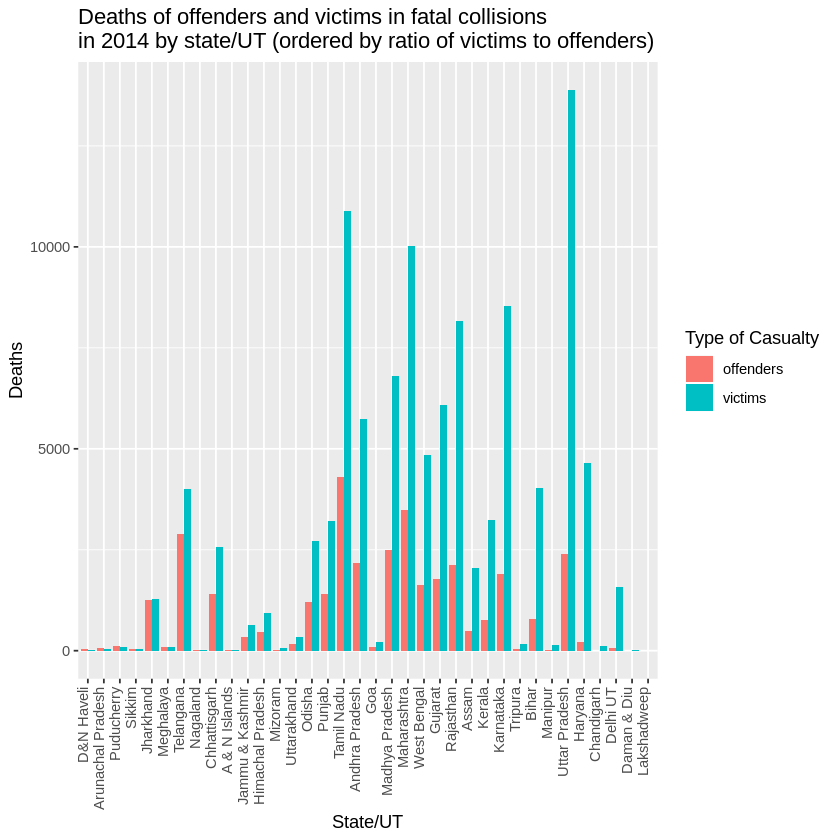

In [8]:
plt <- ggplot(long, aes(x=reorder(states_uts, ratio), y=total, fill=casualty_type)) + 
  geom_bar(position="dodge", stat='identity')
plt <- plt + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0))
plt <- plt + ggtitle(paste0("Deaths of offenders and victims in fatal collisions",
                            "\nin 2014 by state/UT (ordered by ratio of victims to offenders)"))
plt <- plt + labs(x="State/UT", y="Deaths", fill="Type of Casualty")
plt

# Deaths by Mode of Transport in Tamil Nadu

Here, I examine the distribution of accidental deaths by the type of vehicle/mode of transport that caused the accident, for a particular state (Tamil Nadu) in 2014. As expected, the most common vehicles on the road (cars, trucks, two wheelers e.g. motorcycles) made up the majority of accidental deaths, though buses also made up a significant portion, possibly due to their high capacity. Interestingly, deaths due to two wheelers were almost double that of those by cars, a result which might not be observed in North America due to the relative infrequency of motorcycles here as compared to India.

In [0]:
# processing the 2014 data
rgx <- "(\\(Total\\)|^(Bicycle|Pedestrian|Others$))"
tn14 <- df14[df14$states_uts == "Tamil Nadu" & grepl(rgx, df14$crimehead, perl=TRUE) & !grepl("Tractor", df14$crimehead), c(1:3, 12)]
new <- c("SUV \\(7 & 8 Seater\\)", "")
old <- c("SUV \\(7 & 8 Seater\\)/Station Wagon/etc. \\(Total\\)", " \\(Total\\)")
names(new) <- old
tn14[] <- lapply(tn14, function(x) str_replace_all(x, new))
colnames(tn14)[3] <- "cause"
tn14[, 4] <- as.numeric(gsub("[^0-9]", "", tn14[,4]))

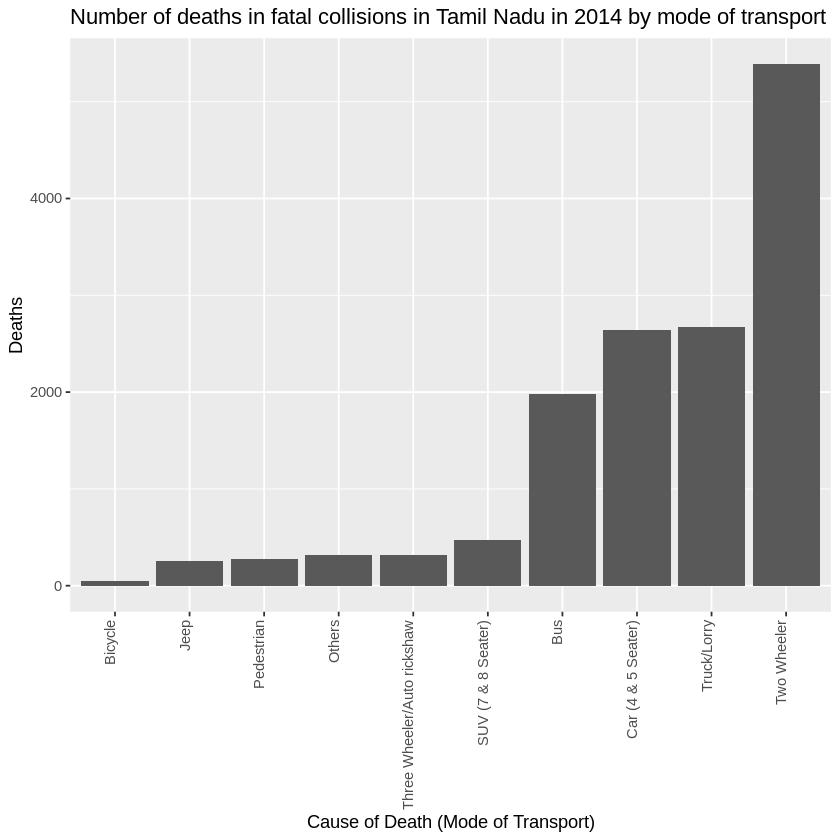

In [10]:
plt <- ggplot(tn14, aes(x=reorder(cause, deaths), y=deaths)) + geom_bar(stat="identity")
plt <- plt + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0))
plt <- plt + ggtitle("Number of deaths in fatal collisions in Tamil Nadu in 2014 by mode of transport")
plt <- plt + labs(x="Cause of Death (Mode of Transport)", y="Deaths")
plt

# Deaths by Mode of Transport in Tamil Nadu across 2001-2014

In [0]:
# standardizing the column titles across all data,
#  assuming collection methods have not changed
new <- c("Truck/Lorry", "Bus", "SUV (7 & 8 Seater)", "Car (4 & 5 Seater)", "Jeep", 
         "Three Wheeler/Auto rickshaw", "Two Wheeler", "Others")
new <- gsub("\\(", "\\\\(", new)
new <- gsub("\\)", "\\\\)", new)
old <- c("Total Truck/Lorry", "Total Bus", "Total Tempo/Vans", "Total Car", 
         "Total Jeep", "^Three Wheeler$", "Two Wheeler", "Others (Please Specify)")
old <- gsub("\\(", "\\\\(", old)
old <- gsub("\\)", "\\\\)", old)
names(new) <- old
selection <- c("Total Truck/Lorry", "Total Bus", "Total Tempo/Vans", 
               "Total Car", "Total Jeep", "Three Wheeler", "Two Wheeler", 
               "Others (Please Specify)", "Bicycle", "Pedestrian")

In [0]:
# processing the 2001-2012 data
temp <- df01[df01$state_ut == "TAMIL NADU", c(1:3, 6)]
tn01 <- temp[temp$cause %in% selection,]
tn01[] <- lapply(tn01, function(x) str_replace_all(x, new))
colnames(tn01) <- c("states_uts", "year", "cause", "deaths")

In [0]:
# processing the 2013 data
temp <- df13[df13$state_ut == "TAMIL NADU", c(1:3, 6)]
tn13 <- temp[temp$cause %in% selection,]
tn13[] <- lapply(tn13, function(x) str_replace_all(x, new))
colnames(tn13) <- c("states_uts", "year", "cause", "deaths")

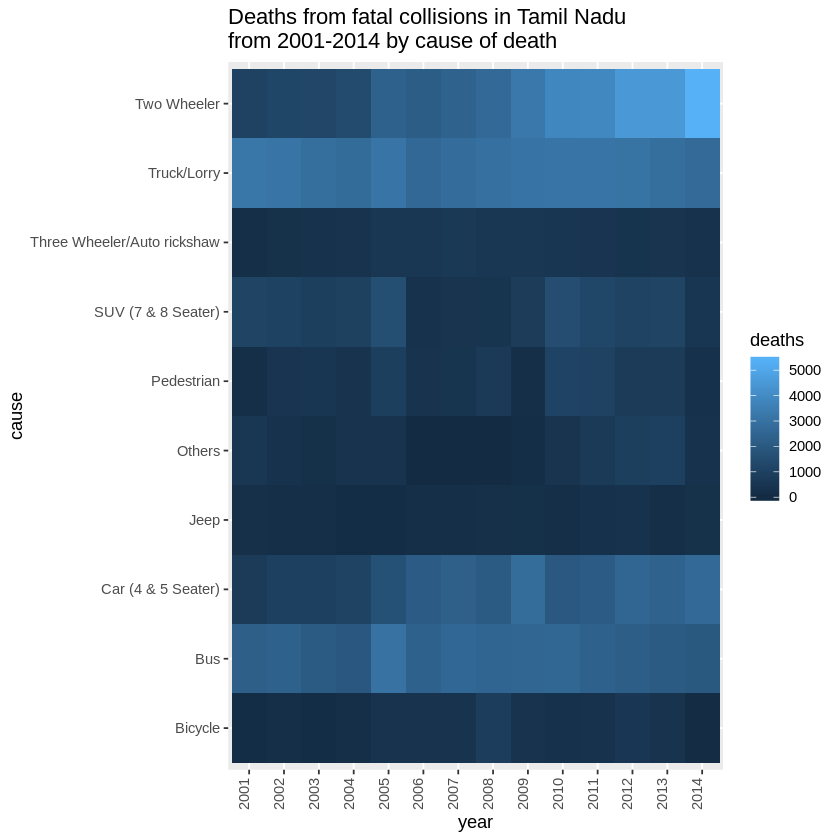

In [14]:
tn <- rbind(tn01, tn13, tn14)
tn[, 4] <- as.numeric(gsub("[^0-9]", "", tn[,4]))
plt2 <- ggplot(tn, aes(x=year, y=cause, fill=deaths)) + geom_tile()
plt2 <- plt2 + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0))
plt2 <- plt2 + ggtitle(paste0("Deaths from fatal collisions in Tamil Nadu",
                              "\nfrom 2001-2014 by cause of death"))
plt2

In [0]:
ggsave("pltRaw.png", plt2, width=11, height=8)

In [0]:
normalize <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}

tnNorm <- spread(tn, cause, deaths)
tnNorm[,3:length(tnNorm)] <- lapply(tnNorm[,3:length(tnNorm)], normalize)
tnNorm <- gather(tnNorm, cause, deaths, 3:length(tnNorm))
plt3 <- ggplot(tnNorm, aes(x=year, y=cause, fill=deaths)) + geom_tile()
plt3 <- plt3 + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0))
plt3 <- plt3 + ggtitle(paste0("Deaths (normalized) from fatal collisions",
                              "\nin Tamil Nadu from 2001-2014 by cause of death"))
plt3 <- plt3 + labs(x="Year", y="Deaths", fill="Normalized Deaths")

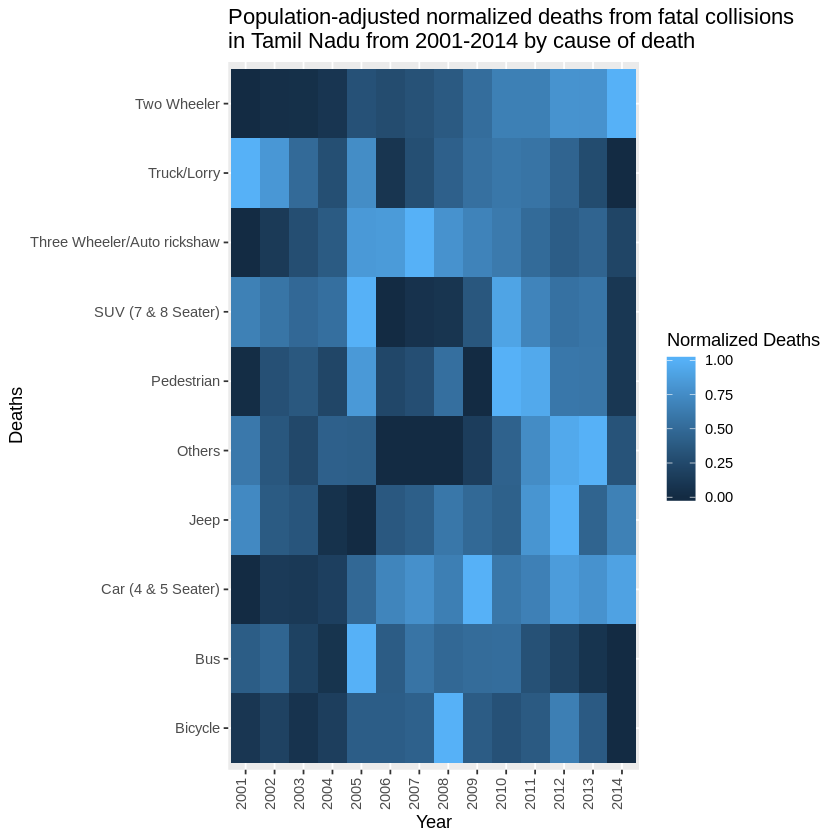

In [17]:
# population of TN in thousands, from the Census of India projections at 
# http://censusindia.gov.in/Census_Data_2001/Projected_Population/Projected_Population.pdf
populations <- numeric()

for (i in c(62406, 62989, 63552, 64096, 64623, 65135, 65629, 66106, 66566, 67012, 67444, 67862, 68265, 68654)) {
  populations <- append(populations, rep(i, 10))
}

tn$population <- populations
tnNorm2 <- spread(tn, cause, deaths)
tnNorm2[,4:length(tnNorm2)] <- lapply(tnNorm2[,4:length(tnNorm2)], function(x) normalize(x/tnNorm2$population))
tnNorm2 <- gather(tnNorm2, cause, deaths, 4:length(tnNorm2))
plt5 <- ggplot(tnNorm2, aes(x=year, y=cause, fill=deaths)) + geom_tile()
plt5 <- plt5 + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0))
plt5 <- plt5 + ggtitle(paste0("Population-adjusted normalized deaths from fatal collisions",
                              "\nin Tamil Nadu from 2001-2014 by cause of death"))
plt5 <- plt5 + labs(x="Year", y="Deaths", fill="Normalized Deaths")
plt5

In [0]:
ggsave("pltPopNorm.png", plt5, width=11, height=8)